In [2]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import os


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import acquire
import prepare

In [3]:
telco = prepare.prep_telco_alternative()
telco

,Unnamed: 0,senior_citizen,tenure,monthly_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,paperless_billing_Yes,churn_Yes,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,contract_type_Month-to-month,contract_type_One year,contract_type_Two year
0,0,0,9,65.60,0,1,1,1,0,0,...,1,0,0,0,0,0,1,0,1,0
1,1,0,9,59.90,1,0,0,1,0,1,...,0,0,0,0,0,0,1,1,0,0
2,2,0,4,73.90,1,0,0,1,0,0,...,1,1,1,0,0,1,0,1,0,0
3,3,1,13,98.00,1,1,0,1,0,0,...,1,1,1,0,0,1,0,1,0,0
4,4,1,3,83.90,0,1,0,1,0,0,...,1,1,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,0,13,55.15,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
7039,7039,0,22,85.10,1,1,0,1,0,1,...,1,1,1,0,0,1,0,1,0,0
7040,7040,0,2,50.30,1,0,0,1,0,0,...,1,0,0,0,0,0,1,1,0,0
7041,7041,0,67,67.85,1,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [4]:
telco.churn_Yes.value_counts()

0    5174
1    1869
Name: churn_Yes, dtype: int64

In [5]:
baseline = telco[telco.churn_Yes == 0]
churn = telco[telco.churn_Yes == 1]
len(baseline)/len(telco)

0.7346301292063041

###  On the surface we might use this as a baseline because it represents the frequency of the mode which is customers who don't churn.  As I have defined it, our positive result is customers who do not leave (i.e. don't churn) while our negative result are the customers who do churn (or leave).  

### Given this and the fact that we are specifically interested in the customers who are leaving, I am not using accuracy as my metric but rather the specificity of the models! 

### The specificity is $\frac{True Negatives}{False Positives + True Negatives}$  In other words what percent of the actual negatives do we catch with out predicted negatives.  This registers as the recall of the 1's in the churn_Yes column as opposed to the recall of the churn 0's.

### Thus the baseline specificity of this situation is assuming everyone is the mode or customers who stay and calculating the result: $\frac{True Negatives}{False Positives + True Negatives}$ = $\frac{0}{1869 + 0}$ = $0$

In [6]:
new_baseline = 0

### However if we were to just pick a customer at random there is a $\frac{1869}{7043}$ = 0.2653698707936959 chance that this customer will leave.  This is the real number to beat.  Note that our random pick is significantly more restrictive than the new_baseline so this is what we will use.

In [7]:
real_number_to_beat = len(churn)/len(telco)
real_number_to_beat

0.2653698707936959

### For our first statistical test I am doing a Chi Squared test for all columns individually compared to the churn_Yes column.

### The generalized Null Hypothesis is that the churn_Yes column is INDEPENDENT of the column in question.
### The generalized Alternative Hypothesis is that the churn_Yes column is DEPENDENT of the column in question.
### Since there are so many to choose from and the number of customers n-value is so high, I have opted to use an alpha < 0.01

In [8]:
for col in telco.columns:
    col = pd.crosstab(telco[col], telco.churn_Yes)
    print(col)
    col_chi2, col_p, col_degf, col_expected = stats.chi2_contingency(col)
    print(f'(chi squared = {col_chi2}, p = {col_p}')
    print('___________________________________________________________')

#IGNORE the CONTINOUS variable monthly charges

churn_Yes   0  1
Unnamed: 0      
0           1  0
1           1  0
2           0  1
3           0  1
4           0  1
...        .. ..
7038        1  0
7039        0  1
7040        1  0
7041        1  0
7042        1  0

[7043 rows x 2 columns]
(chi squared = 7043.0, p = 0.49439767459438705
___________________________________________________________
churn_Yes          0     1
senior_citizen            
0               4508  1393
1                666   476
(chi squared = 159.42630036838742, p = 1.510066805092378e-36
___________________________________________________________
churn_Yes    0    1
tenure             
0           11    0
1          233  380
2          115  123
3          106   94
4           93   83
5           69   64
6           70   40
7           80   51
8           81   42
9           73   46
10          71   45
11          68   31
12          79   38
13          71   38
14          52   24
15          62   37
16          52   28
17          61   26
18          73   2

### "Unnamed: 0", "gender_male", "phone_service_Yes", "multiple_lines_No phone service" all do not meet the p-value we set and thus we do not have sufficient evidence to reject the null hypothesis.  Therefore I am dropping them all from the analysis.  "Unnamed: 0" is just an id number so it makes sense that they are independant events...kinda goes without saying but a good sanity check.

In [9]:
telco = telco.drop(columns=['Unnamed: 0', 'gender_Male', 'phone_service_Yes', 'multiple_lines_No phone service'])

<Axes: xlabel='tenure', ylabel='monthly_charges'>

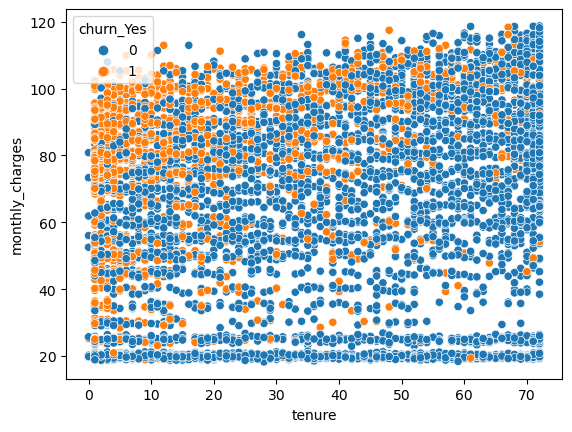

In [10]:
sns.scatterplot(data=telco, x='tenure', y='monthly_charges', hue='churn_Yes')

### This scatterplot seemed to show a clear relationship in a multivariable sense...The newer the Customer AND the more the customer paid seemed to have a clear impact on Churn Rates!

In [11]:
telco_churn = telco[telco.churn_Yes == 1]

### Looking at the tenure vs monthly_charges graph it seemed as though there were a correlation between tenure and monthly_charges for churned customers.  I masked the telco for churned customers and tried to see if there was a correlation.

### Null Hypothesis:  There is no linear correlation between the tenure and monthly charges
### Alternative Hypothesis:  There is a linear correlation
### choose an alpha < 0.05

<Axes: xlabel='tenure', ylabel='monthly_charges'>

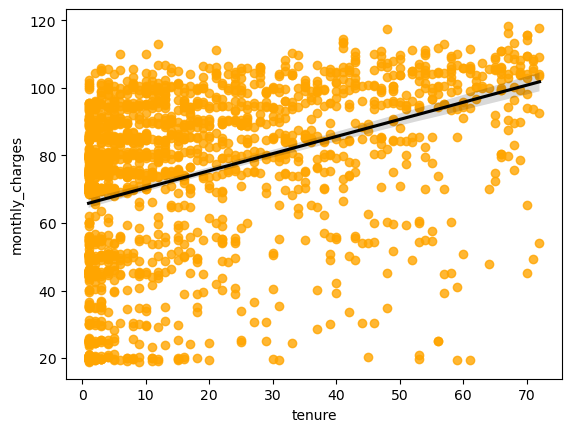

In [12]:
sns.regplot(data=telco_churn, x='tenure', y='monthly_charges', scatter_kws={'color':'orange'}, line_kws={'color':'black'})

In [13]:
stats.pearsonr(telco_churn.tenure, telco_churn.monthly_charges)

PearsonRResult(statistic=0.401285600132126, pvalue=3.0121978116585465e-73)

### The Pearson's test shows a p-value low enough to reject the null and see there is a linar correlation of .401 which is a moderate correlation.  A Spearmanr test might show even stronger since it seems a monotonically increasing curve would fit even better.

### Null Hypothesis:  There is a no monotonic correlation between tenure and monthly charges
### Alt Hypothesis:  There is a monotonic correlation between tenure and monthly charges
### Alpha < 0.05

In [14]:
stats.spearmanr(telco_churn.tenure, telco_churn.monthly_charges, axis=0)

SignificanceResult(statistic=0.4843751919531249, pvalue=1.5136016239109236e-110)

### As expected the Spearman's test gives a very low p-value suggesting that we can reject the null and shows an even stronger correlation of .484.  Inspection of the graph clearly indicates that it is monotonically increasing.

###  These two results combined suggest that it might prove valuable to combine the two metrics into a new one.  I created a new column called tenure_charge_ratio which is the tenure divided by monthly charges

### Also, I normalized the tenure and monthly charges so as to optimize the knn predictions.  These should not have an adverse effect of trees random forests or the logistic regression models as the calculations are scaled accordingly.  In addition the logistic regression should be simplified as well.

In [15]:
telco['tenure_charge_ratio'] = telco.tenure/telco.monthly_charges
telco['tenure_normalized'] = (telco.tenure - telco.tenure.min()) / (telco.tenure.max() - telco.tenure.min())
telco['monthly_charges_normalized'] = (telco.monthly_charges - telco.monthly_charges.min()) / (telco.monthly_charges.max() - telco.monthly_charges.min())
telco = telco.drop(columns=['tenure', 'monthly_charges'])
telco

,senior_citizen,partner_Yes,dependents_Yes,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,...,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,tenure_charge_ratio,tenure_normalized,monthly_charges_normalized
0,0,1,1,0,0,1,0,1,1,0,...,0,0,0,1,0,1,0,0.137195,0.125000,0.471144
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0.150250,0.125000,0.414428
2,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0.054127,0.055556,0.553731
3,1,1,0,0,0,1,1,0,1,1,...,0,0,1,0,1,0,0,0.132653,0.180556,0.793532
4,1,1,0,0,0,0,0,1,1,0,...,0,0,0,1,1,0,0,0.035757,0.041667,0.653234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0.235721,0.180556,0.367164
7039,0,1,0,1,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0.258519,0.305556,0.665174
7040,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0.039761,0.027778,0.318905
7041,0,1,1,0,1,0,1,1,0,1,...,0,0,0,1,0,0,1,0.987472,0.930556,0.493532


### A quick Chi Squared test comparing the new column with the churn_Yes column
### Null hypothesis:  The tenure_charge_ratio and the churn_Yes columns are independent
### Alt hypothesis:  The tenure_charge_ratio and the churn_Yes columns are independent
### Alpha < 0.05

In [16]:
ratio = pd.crosstab(telco.tenure_charge_ratio, telco.churn_Yes)
ratio_chi2, ratio_p, ratio_degf, ratio_expected = stats.chi2_contingency(ratio)
ratio_chi2, ratio_p

(6322.159485046925, 0.005930175959581971)

### With a p-value of .006 we can reject the null and conclude that there is a dependence that we may take advantage of.

<Axes: xlabel='churn_Yes', ylabel='tenure_charge_ratio'>

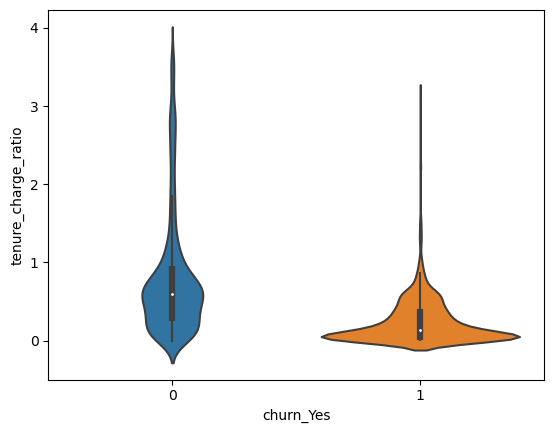

In [17]:
sns.violinplot(data=telco, x='churn_Yes', y='tenure_charge_ratio')

### A quick violin plot shows that the churn rate is very high when the tenure_charge_ratio is low.

In [18]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco, 'churn_Yes')

# Decision Tree

[0 0 0 0 0]
[[0.63736264 0.36263736]
 [0.63736264 0.36263736]
 [0.63736264 0.36263736]
 [0.83804627 0.16195373]
 [0.96358543 0.03641457]]


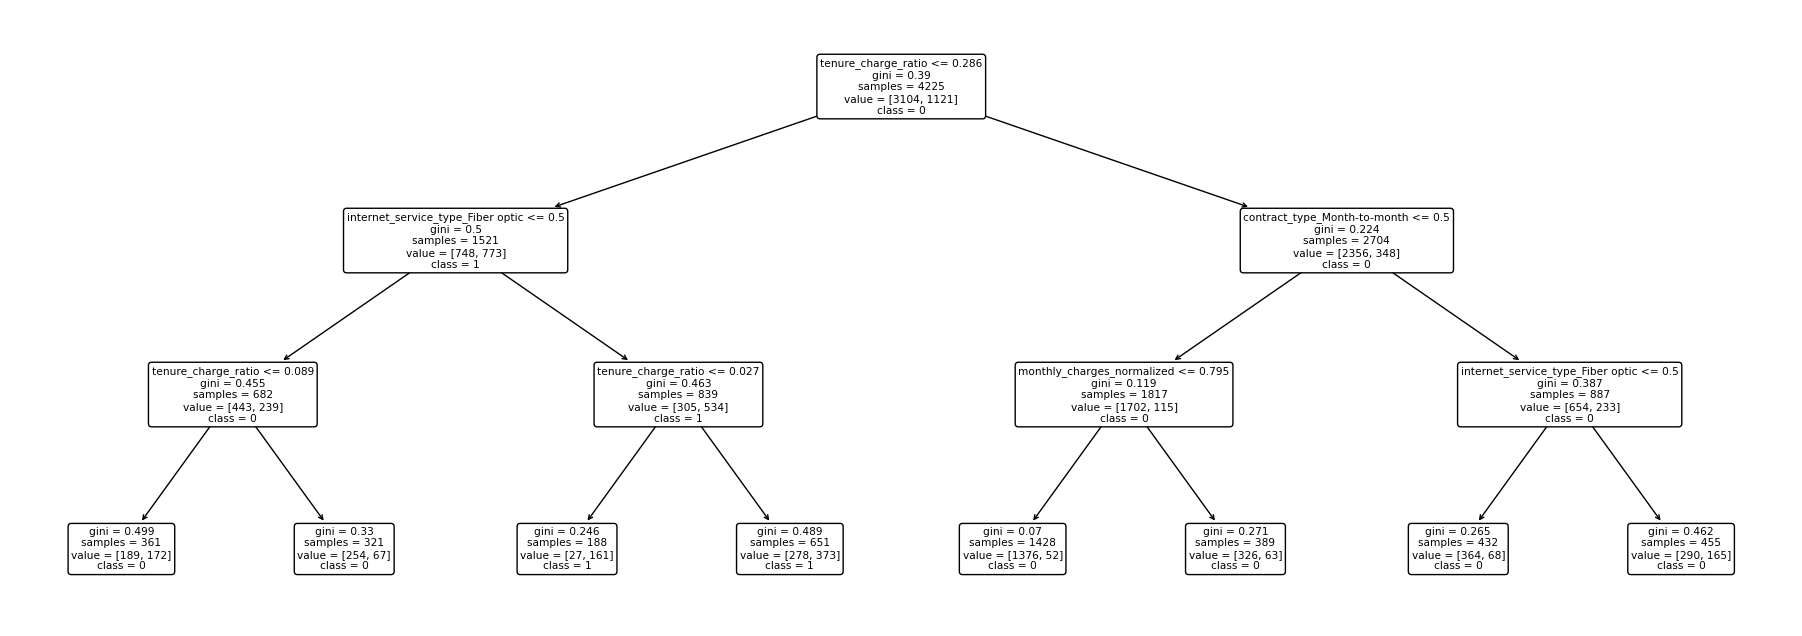

In [19]:
clf = DecisionTreeClassifier(max_depth=3, random_state=823)
clf = clf.fit(X_train, y_train)
plt.figure(figsize=(23, 8))
plot_tree(clf, feature_names=X_train.columns, class_names=clf.classes_.astype('str'), rounded=True)
y_pred_clf = clf.predict(X_train)
print(y_pred_clf[0:5])
y_pred_proba_clf = clf.predict_proba(X_train)
print(y_pred_proba_clf[0:5])
y_val_clf = clf.predict(X_validate)
y_val_proba_clf = clf.predict_proba(X_validate)

### The tree confirms that the new ratio column is the highest priority so this should weigh beneficially across all tests!

In [20]:
print('Accuracy of Decision Tree classifier on training set: {:.8f}'
      .format(clf.score(X_train, y_train)))
print(confusion_matrix(y_train, y_pred_clf))
print(y_train.value_counts())
labels = sorted(y_train.unique())
results = pd.DataFrame(confusion_matrix(y_train, y_pred_clf), index=labels, columns=labels)
results

Accuracy of Decision Tree classifier on training set: 0.78887574
[[2799  305]
 [ 587  534]]
0    3104
1    1121
Name: churn_Yes, dtype: int64


,0,1
0,2799,305
1,587,534


In [21]:
print(confusion_matrix(y_train, y_pred_clf))
print(classification_report(y_train, y_pred_clf))
print(confusion_matrix(y_validate, y_val_clf))
print(classification_report(y_validate, y_val_clf))

[[2799  305]
 [ 587  534]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      3104
           1       0.64      0.48      0.54      1121

    accuracy                           0.79      4225
   macro avg       0.73      0.69      0.70      4225
weighted avg       0.78      0.79      0.78      4225

[[914 121]
 [199 175]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1035
           1       0.59      0.47      0.52       374

    accuracy                           0.77      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.76      0.77      0.76      1409



# Random Forrest

In [22]:
rf = RandomForestClassifier(bootstrap=True,
                            class_weight=None,
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=18,
                            max_depth=8,
                            random_state=823)
rf.fit(X_train, y_train)
print(rf.feature_importances_)
y_pred_rf = rf.predict(X_train)
print(y_pred_rf[0:10])
y_pred_proba_rf = rf.predict_proba(X_train)
print(y_pred_proba_rf)
y_val_rf = rf.predict(X_validate)
y_val_proba_rf = rf.predict_proba(X_validate)

[0.00863103 0.01063269 0.01035647 0.01514524 0.01461095 0.01316006
 0.00648322 0.02228326 0.00890139 0.00780163 0.01875505 0.0517694
 0.02681534 0.00784077 0.05654419 0.00691545 0.15400066 0.01953369
 0.04892015 0.22214125 0.15859712 0.11016099]
[0 0 0 0 0 0 0 0 0 0]
[[0.53951899 0.46048101]
 [0.80233723 0.19766277]
 [0.61361259 0.38638741]
 ...
 [0.98111439 0.01888561]
 [0.87247082 0.12752918]
 [0.73584328 0.26415672]]


In [23]:
print(confusion_matrix(y_train, y_pred_rf))
print(classification_report(y_train, y_pred_rf))
print(confusion_matrix(y_validate, y_val_rf))
print(classification_report(y_validate, y_val_rf))

[[2877  227]
 [ 477  644]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3104
           1       0.74      0.57      0.65      1121

    accuracy                           0.83      4225
   macro avg       0.80      0.75      0.77      4225
weighted avg       0.83      0.83      0.83      4225

[[930 105]
 [184 190]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.64      0.51      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.79      0.79      1409



In [24]:
model_set = []
model_accuracies = {}

for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform', p=1)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_train)
    y_pred_proba = knn.predict_proba(X_train)
    
    y_val = knn.predict(X_validate)
    y_val_proba = knn.predict_proba(X_validate)
    
    st = round(confusion_matrix(y_train, y_pred)[1][1]/(confusion_matrix(y_train, y_pred)[1][0] + confusion_matrix(y_train, y_pred))[1][1], 5)
    sv = round(confusion_matrix(y_validate, y_val)[1][1]/(confusion_matrix(y_validate, y_val)[1][0] + confusion_matrix(y_validate, y_val))[1][1], 5)
    model_set.append(knn)
    model_accuracies[f'{i} neighbors'] = {
        'train_score' : round(knn.score(X_train, y_train), 5),
        'validate_score' : round(knn.score(X_validate, y_validate), 5),
        'Sensitivity_train' : st,
        'Sensitivity_validate' : sv,
        'Sensitivity_difference' : (st-sv),
        'Just_for_analysis_TP' : (confusion_matrix(y_train, y_pred)[0][0]/3104), 
        'Just_for_analysis_TP_val' : (confusion_matrix(y_validate, y_val)[0][0]/1121)
    }

In [25]:
pd.DataFrame(model_accuracies).T

,train_score,validate_score,Sensitivity_train,Sensitivity_validate,Sensitivity_difference,Just_for_analysis_TP,Just_for_analysis_TP_val
1 neighbors,0.99669,0.73101,0.99554,0.50267,0.49287,0.997101,0.751115
2 neighbors,0.87172,0.77218,0.51650,0.36096,0.15554,1.000000,0.850134
3 neighbors,0.85988,0.76082,0.69581,0.55615,0.13966,0.919137,0.770740
4 neighbors,0.83716,0.77289,0.49509,0.40642,0.08867,0.960696,0.835861
5 neighbors,0.83314,0.77928,0.64407,0.55080,0.09327,0.901418,0.795718
6 neighbors,0.82888,0.78779,0.52453,0.45989,0.06464,0.938789,0.836753
7 neighbors,0.82107,0.78282,0.61998,0.54545,0.07453,0.893686,0.801963
8 neighbors,0.82178,0.79702,0.53880,0.52139,0.01741,0.923969,0.827832
9 neighbors,0.81112,0.79063,0.60303,0.58289,0.02014,0.886276,0.799286
10 neighbors,0.81420,0.79702,0.53256,0.54011,-0.00755,0.915915,0.821588


# KNN with K=10

In [26]:
model_accuracies = []
    
knn10 = KNeighborsClassifier(n_neighbors=15, weights='uniform', p=1)
knn10.fit(X_train, y_train)
    
y_pred_knn = knn10.predict(X_train)
y_pred_proba_knn = knn10.predict_proba(X_train)
    
y_val_knn = knn10.predict(X_validate)
y_val_proba_knn = knn10.predict_proba(X_validate)


#print(knn.feature_importances_)
y_pred_knn10 = knn10.predict(X_train)
print(y_pred_knn10[0:10])
y_pred_proba_knn10 = knn10.predict_proba(X_train)
print(y_pred_proba_knn10)
y_val_knn10 = knn10.predict(X_validate)
y_val_proba_knn = knn10.predict_proba(X_validate)

[1 0 1 0 0 0 0 0 0 0]
[[0.26666667 0.73333333]
 [0.53333333 0.46666667]
 [0.4        0.6       ]
 ...
 [0.93333333 0.06666667]
 [0.8        0.2       ]
 [0.86666667 0.13333333]]


In [27]:
print(confusion_matrix(y_train, y_pred_knn))
print(classification_report(y_train, y_pred_knn))
print(confusion_matrix(y_validate, y_val_knn))
print(classification_report(y_validate, y_val_knn))

[[2750  354]
 [ 439  682]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3104
           1       0.66      0.61      0.63      1121

    accuracy                           0.81      4225
   macro avg       0.76      0.75      0.75      4225
weighted avg       0.81      0.81      0.81      4225

[[886 149]
 [157 217]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1035
           1       0.59      0.58      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



# Logistic Regression

In [28]:
logit = LogisticRegression(C=1, random_state=823, intercept_scaling=1, max_iter=1000, solver='lbfgs')
logit.fit(X_train, y_train)
    
y_pred_log = logit.predict(X_train)
y_pred_proba_log = logit.predict_proba(X_train)
        
y_val_log = logit.predict(X_validate)
y_val_proba_log = logit.predict_proba(X_validate)
    

y_pred_logit = logit.predict(X_train)
print(y_pred_logit[0:10])
y_pred_proba_logit = logit.predict_proba(X_train)
print(y_pred_proba_logit)
y_val_logit = logit.predict(X_validate)
y_val_proba_logit = logit.predict_proba(X_validate)

[0 0 0 0 0 0 0 0 0 0]
[[0.52944612 0.47055388]
 [0.77109381 0.22890619]
 [0.65421696 0.34578304]
 ...
 [0.97755149 0.02244851]
 [0.86766828 0.13233172]
 [0.91165909 0.08834091]]


In [29]:
print(confusion_matrix(y_train, y_pred_log))
print(classification_report(y_train, y_pred_log))
print(confusion_matrix(y_validate, y_val_log))
print(classification_report(y_validate, y_val_log))

[[2793  311]
 [ 500  621]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3104
           1       0.67      0.55      0.60      1121

    accuracy                           0.81      4225
   macro avg       0.76      0.73      0.74      4225
weighted avg       0.80      0.81      0.80      4225

[[921 114]
 [172 202]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



### It is interesting that this Logistic Regression result is almost as good as the KNN and better than the decision tree as this algorithm SHOULD NOT be used in this dataset.  One of the main assumptions needed for this model is that the features are independent and the analysis I did during project collection indicates that these features are highly dependent on each other.  Extracting an independent set proved difficult but I attempted it with the following loop.

In [35]:
independent_list = []
dependent_list = []

for i in telco.columns:
    for j in telco.columns:
        col = pd.crosstab(telco[i], telco[j])
        
        col_chi2, col_p, col_degf, col_expected = stats.chi2_contingency(col)
        if col_p < .65:
            print(i)
            print(j)
            independent_list.append(i)
            independent_list.append(j)
            print(f'(chi squared = {col_chi2}, p = {col_p}')
            print('___________________________________________________________')
        else:
            continue

senior_citizen
senior_citizen
(chi squared = 7035.641146264212, p = 0.0
___________________________________________________________
senior_citizen
partner_Yes
(chi squared = 1.8240787010909085, p = 0.17682854387458363
___________________________________________________________
senior_citizen
dependents_Yes
(chi squared = 312.86220491649726, p = 5.196628882267003e-70
___________________________________________________________
senior_citizen
multiple_lines_Yes
(chi squared = 143.13369250096522, p = 5.495405921872713e-33
___________________________________________________________
senior_citizen
online_security_Yes
(chi squared = 10.291838997807975, p = 0.0013361985437299678
___________________________________________________________
senior_citizen
online_backup_Yes
(chi squared = 30.834691307120917, p = 2.80969853405986e-08
___________________________________________________________
senior_citizen
device_protection_Yes
(chi squared = 24.535807606722024, p = 7.294162071306776e-07
_________

dependents_Yes
tenure_charge_ratio
(chi squared = 6143.560634274402, p = 0.17752994646641881
___________________________________________________________
dependents_Yes
tenure_normalized
(chi squared = 285.2102765430112, p = 3.705920641986293e-27
___________________________________________________________
dependents_Yes
monthly_charges_normalized
(chi squared = 1713.2919698731384, p = 0.012250556656761415
___________________________________________________________
multiple_lines_Yes
senior_citizen
(chi squared = 143.13369250096522, p = 5.495405921872713e-33
___________________________________________________________
multiple_lines_Yes
partner_Yes
(chi squared = 141.55419578148934, p = 1.2171944722985597e-32
___________________________________________________________
multiple_lines_Yes
dependents_Yes
(chi squared = 4.1287500058228765, p = 0.04216048182397241
___________________________________________________________
multiple_lines_Yes
multiple_lines_Yes
(chi squared = 7038.900397558333,

online_backup_Yes
tenure_charge_ratio
(chi squared = 6506.214195557055, p = 1.850451381091667e-05
___________________________________________________________
online_backup_Yes
tenure_normalized
(chi squared = 1005.280894118313, p = 1.8496141894990172e-164
___________________________________________________________
online_backup_Yes
monthly_charges_normalized
(chi squared = 3175.931111542167, p = 5.502890439256061e-109
___________________________________________________________
device_protection_Yes
senior_citizen
(chi squared = 24.535807606722024, p = 7.294162071306776e-07
___________________________________________________________
device_protection_Yes
partner_Yes
(chi squared = 165.9215766350183, p = 5.754358208131943e-38
___________________________________________________________
device_protection_Yes
dependents_Yes
(chi squared = 1.3096301257716019, p = 0.2524616340149424
___________________________________________________________
device_protection_Yes
multiple_lines_Yes
(chi squar

streaming_tv_Yes
tenure_charge_ratio
(chi squared = 6558.297746595141, p = 2.378137966547354e-06
___________________________________________________________
streaming_tv_Yes
tenure_normalized
(chi squared = 647.2408554427689, p = 2.1876943847285335e-93
___________________________________________________________
streaming_tv_Yes
monthly_charges_normalized
(chi squared = 4139.134070744171, p = 3.084600533235019e-227
___________________________________________________________
streaming_movies_Yes
senior_citizen
(chi squared = 101.04931273225958, p = 8.972171144049886e-24
___________________________________________________________
streaming_movies_Yes
partner_Yes
(chi squared = 96.60998953119413, p = 8.442125821661448e-23
___________________________________________________________
streaming_movies_Yes
dependents_Yes
(chi squared = 10.94598860377264, p = 0.0009380648201644438
___________________________________________________________
streaming_movies_Yes
multiple_lines_Yes
(chi squared = 4

churn_Yes
tenure_charge_ratio
(chi squared = 6322.1594850469255, p = 0.005930175959581843
___________________________________________________________
churn_Yes
tenure_normalized
(chi squared = 1065.3308567510544, p = 1.2807811055496877e-176
___________________________________________________________
churn_Yes
monthly_charges_normalized
(chi squared = 2123.609129997958, p = 1.8852727784254426e-18
___________________________________________________________
internet_service_type_Fiber optic
senior_citizen
(chi squared = 457.79046874710957, p = 1.4545408290614115e-101
___________________________________________________________
internet_service_type_Fiber optic
dependents_Yes
(chi squared = 192.92378129621784, p = 7.314046016788485e-44
___________________________________________________________
internet_service_type_Fiber optic
multiple_lines_Yes
(chi squared = 942.3884363724378, p = 5.988479897300846e-207
___________________________________________________________
internet_service_type_Fib

payment_type_Credit card (automatic)
tenure_charge_ratio
(chi squared = 6224.057764495286, p = 0.04989553517459624
___________________________________________________________
payment_type_Credit card (automatic)
tenure_normalized
(chi squared = 466.55982291718533, p = 4.164018920463423e-59
___________________________________________________________
payment_type_Credit card (automatic)
monthly_charges_normalized
(chi squared = 1666.7190312544153, p = 0.07261200871438714
___________________________________________________________
payment_type_Electronic check
senior_citizen
(chi squared = 206.6915990564006, p = 7.239221121860504e-47
___________________________________________________________
payment_type_Electronic check
partner_Yes
(chi squared = 49.165408337939525, p = 2.352630782505898e-12
___________________________________________________________
payment_type_Electronic check
dependents_Yes
(chi squared = 159.1323411758413, p = 1.7507513311859364e-36
________________________________

contract_type_Month-to-month
tenure_charge_ratio
(chi squared = 6628.439767759832, p = 1.1251510627726333e-07
___________________________________________________________
contract_type_Month-to-month
tenure_normalized
(chi squared = 3037.824910683394, p = 0.0
___________________________________________________________
contract_type_Month-to-month
monthly_charges_normalized
(chi squared = 2266.846631535819, p = 3.3324878300765924e-27
___________________________________________________________
contract_type_One year
senior_citizen
(chi squared = 14.766487747497408, p = 0.00012167885644089338
___________________________________________________________
contract_type_One year
partner_Yes
(chi squared = 47.85973870026655, p = 4.578272851677103e-12
___________________________________________________________
contract_type_One year
dependents_Yes
(chi squared = 32.554776602435446, p = 1.1587998104610727e-08
___________________________________________________________
contract_type_One year
online

tenure_charge_ratio
online_backup_Yes
(chi squared = 6506.214195557055, p = 1.850451381091667e-05
___________________________________________________________
tenure_charge_ratio
device_protection_Yes
(chi squared = 6531.226414076407, p = 7.068115651643852e-06
___________________________________________________________
tenure_charge_ratio
tech_support_Yes
(chi squared = 6570.697557907644, p = 1.4203622886774036e-06
___________________________________________________________
tenure_charge_ratio
streaming_tv_Yes
(chi squared = 6558.297746595141, p = 2.378137966547354e-06
___________________________________________________________
tenure_charge_ratio
streaming_movies_Yes
(chi squared = 6603.2309277868835, p = 3.498190286678256e-07
___________________________________________________________
tenure_charge_ratio
paperless_billing_Yes
(chi squared = 6174.722508414154, p = 0.1141612286878258
___________________________________________________________
tenure_charge_ratio
churn_Yes
(chi squared =

monthly_charges_normalized
payment_type_Mailed check
(chi squared = 2267.741147452326, p = 2.9085092639983493e-27
___________________________________________________________
monthly_charges_normalized
contract_type_Month-to-month
(chi squared = 2266.846631535819, p = 3.3324878300765924e-27
___________________________________________________________
monthly_charges_normalized
contract_type_One year
(chi squared = 1762.4358071474308, p = 0.0010696675782613616
___________________________________________________________
monthly_charges_normalized
contract_type_Two year
(chi squared = 2204.967635593821, p = 3.0226628346138334e-23
___________________________________________________________
monthly_charges_normalized
tenure_charge_ratio
(chi squared = 10658121.914899664, p = 0.0
___________________________________________________________
monthly_charges_normalized
tenure_normalized
(chi squared = 117599.75576015131, p = 9.036150061814391e-14
___________________________________________________

### Furthermore, the Chi Squared test cannot prove the Null Hypothesis so this was truly a stab in the dark.  That said I got the following interesting results

In [31]:
independent_list.append('churn_Yes')
telco_ind = telco.drop(columns=[col for col in telco if col not in independent_list])
telco_ind.T

,0,1,2,3,4,5,6,7,8,9,...,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
senior_citizen,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
partner_Yes,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
dependents_Yes,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
multiple_lines_Yes,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
online_security_Yes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
online_backup_Yes,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
device_protection_Yes,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
tech_support_Yes,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
streaming_tv_Yes,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
paperless_billing_Yes,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000


### Rerun Logistic Regression with 'Independent' List:

In [32]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco_ind, 'churn_Yes')

In [33]:
logit = LogisticRegression(C=1, random_state=823, intercept_scaling=1, max_iter=1000, solver='lbfgs')
logit.fit(X_train, y_train)
    
y_pred_log = logit.predict(X_train)
y_pred_proba_log = logit.predict_proba(X_train)
        
y_val_log = logit.predict(X_validate)
y_val_proba_log = logit.predict_proba(X_validate)
    

y_pred_logit = logit.predict(X_train)
print(y_pred_logit[0:10])
y_pred_proba_logit = logit.predict_proba(X_train)
print(y_pred_proba_logit)
y_val_logit = logit.predict(X_validate)
y_val_proba_logit = logit.predict_proba(X_validate)

[1 0 0 0 0 0 0 0 0 0]
[[0.48404607 0.51595393]
 [0.72845305 0.27154695]
 [0.6998933  0.3001067 ]
 ...
 [0.97329982 0.02670018]
 [0.86832086 0.13167914]
 [0.91157001 0.08842999]]


In [34]:
print(confusion_matrix(y_train, y_pred_log))
print(classification_report(y_train, y_pred_log))
print(confusion_matrix(y_validate, y_val_log))
print(classification_report(y_validate, y_val_log))

[[2790  314]
 [ 509  612]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3104
           1       0.66      0.55      0.60      1121

    accuracy                           0.81      4225
   macro avg       0.75      0.72      0.73      4225
weighted avg       0.80      0.81      0.80      4225

[[916 119]
 [175 199]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



### Taking out highly dependent columns made the result worse.  Okay?  I'm gonna try and figure out why.

In [312]:
telco.columns

Index(['senior_citizen', 'partner_Yes', 'dependents_Yes', 'multiple_lines_Yes',
       'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes',
       'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes',
       'paperless_billing_Yes', 'churn_Yes',
       'internet_service_type_Fiber optic', 'internet_service_type_None',
       'payment_type_Credit card (automatic)', 'payment_type_Electronic check',
       'payment_type_Mailed check', 'contract_type_Month-to-month',
       'contract_type_One year', 'contract_type_Two year',
       'tenure_charge_ratio', 'tenure_normalized',
       'monthly_charges_normalized'],
      dtype='object')

In [313]:
telco_drivers = telco.drop(columns=['senior_citizen', 'partner_Yes', 'dependents_Yes', 'multiple_lines_Yes',
       'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes',
       'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes',
       'paperless_billing_Yes', 'internet_service_type_None',
       'payment_type_Credit card (automatic)', 'payment_type_Electronic check',
       'payment_type_Mailed check',
       'contract_type_One year', 'contract_type_Two year', 'tenure_normalized',
       'monthly_charges_normalized', 'tenure_charge_ratio'])
telco_drivers.columns

Index(['churn_Yes', 'internet_service_type_Fiber optic',
       'contract_type_Month-to-month'],
      dtype='object')

### Rerun Logistic Regression with truly "almost" independent 'Driver' List:

In [320]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco_drivers, 'churn_Yes')

In [321]:
logit = LogisticRegression(C=1, random_state=823, intercept_scaling=1, max_iter=1000, solver='lbfgs')
logit.fit(X_train, y_train)
    
y_pred_log = logit.predict(X_train)
y_pred_proba_log = logit.predict_proba(X_train)
        
y_val_log = logit.predict(X_validate)
y_val_proba_log = logit.predict_proba(X_validate)
    

y_pred_logit = logit.predict(X_train)
print(y_pred_logit[0:10])
y_pred_proba_logit = logit.predict_proba(X_train)
print(y_pred_proba_logit)
y_val_logit = logit.predict(X_validate)
y_val_proba_logit = logit.predict_proba(X_validate)

[1 1 1 0 0 0 0 0 0 0]
[[0.44588843 0.55411157]
 [0.44588843 0.55411157]
 [0.44588843 0.55411157]
 ...
 [0.95885647 0.04114353]
 [0.72225034 0.27774966]
 [0.8782248  0.1217752 ]]


In [322]:
print(confusion_matrix(y_train, y_pred_log))
print(classification_report(y_train, y_pred_log))
print(confusion_matrix(y_validate, y_val_log))
print(classification_report(y_validate, y_val_log))

[[2531  573]
 [ 426  695]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      3104
           1       0.55      0.62      0.58      1121

    accuracy                           0.76      4225
   macro avg       0.70      0.72      0.71      4225
weighted avg       0.77      0.76      0.77      4225

[[820 215]
 [140 234]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1035
           1       0.52      0.63      0.57       374

    accuracy                           0.75      1409
   macro avg       0.69      0.71      0.70      1409
weighted avg       0.77      0.75      0.75      1409



In [323]:
model_set = []
model_accuracies = {}

for i in range(-3,3):
    logit = LogisticRegression(C=10**i, random_state=823, intercept_scaling=1, max_iter=1000, solver='lbfgs')
    logit.fit(X_train, y_train)
    
    y_pred = logit.predict(X_train)
    y_pred_proba = logit.predict_proba(X_train)
        
    y_val = logit.predict(X_validate)
    y_val_proba = logit.predict_proba(X_validate)
    
    st = round(confusion_matrix(y_train, y_pred)[1][1]/(confusion_matrix(y_train, y_pred)[1][0] + confusion_matrix(y_train, y_pred))[1][1], 5)
    sv = round(confusion_matrix(y_validate, y_val)[1][1]/(confusion_matrix(y_validate, y_val)[1][0] + confusion_matrix(y_validate, y_val))[1][1], 5)
    model_set.append(logit)
    model_accuracies[f'$10^{i}$'] = {
        'train_score' : round(logit.score(X_train, y_train), 5),
        'validate_score' : round(logit.score(X_validate, y_validate), 5),
        'Sensitivity_train' : st,
        'Sensitivity_validate' : sv,
        'Sensitivity_difference' : (st-sv),
        'Just_for_analysis_TP' : (confusion_matrix(y_train, y_pred)[0][0]/3104), 
        'Just_for_analysis_TP_val' : (confusion_matrix(y_validate, y_val)[0][0]/1121),
    }




In [324]:
model_set

[LogisticRegression(C=0.001, max_iter=1000, random_state=823),
 LogisticRegression(C=0.01, max_iter=1000, random_state=823),
 LogisticRegression(C=0.1, max_iter=1000, random_state=823),
 LogisticRegression(C=1, max_iter=1000, random_state=823),
 LogisticRegression(C=10, max_iter=1000, random_state=823),
 LogisticRegression(C=100, max_iter=1000, random_state=823)]

In [325]:
model_accuracies

{'$10^-3$': {'train_score': 0.73467,
  'validate_score': 0.73456,
  'Sensitivity_train': 0.0,
  'Sensitivity_validate': 0.0,
  'Sensitivity_difference': 0.0,
  'Just_for_analysis_TP': 1.0,
  'Just_for_analysis_TP_val': 0.9232827832292596},
 '$10^-2$': {'train_score': 0.73467,
  'validate_score': 0.73456,
  'Sensitivity_train': 0.0,
  'Sensitivity_validate': 0.0,
  'Sensitivity_difference': 0.0,
  'Just_for_analysis_TP': 1.0,
  'Just_for_analysis_TP_val': 0.9232827832292596},
 '$10^-1$': {'train_score': 0.76355,
  'validate_score': 0.74805,
  'Sensitivity_train': 0.61998,
  'Sensitivity_validate': 0.62567,
  'Sensitivity_difference': -0.005689999999999973,
  'Just_for_analysis_TP': 0.8153994845360825,
  'Just_for_analysis_TP_val': 0.7314897413024085},
 '$10^0$': {'train_score': 0.76355,
  'validate_score': 0.74805,
  'Sensitivity_train': 0.61998,
  'Sensitivity_validate': 0.62567,
  'Sensitivity_difference': -0.005689999999999973,
  'Just_for_analysis_TP': 0.8153994845360825,
  'Just_fo

In [326]:
y_pred_proba = (y_pred_proba_clf + y_pred_proba_rf + y_pred_proba_knn10 + y_pred_proba_logit)/4
y_pred_proba[0:10]

array([[0.47235918, 0.52764082],
       [0.60473041, 0.39526959],
       [0.52421591, 0.47578409],
       [0.87470291, 0.12529709],
       [0.96938188, 0.03061812],
       [0.89702824, 0.10297176],
       [0.97919693, 0.02080307],
       [0.82904553, 0.17095447],
       [0.97963311, 0.02036689],
       [0.61717466, 0.38282534]])

In [327]:
y_pred = y_pred_proba.round()
y_pred = y_pred.astype('uint8')
y_pred.dtype()

TypeError: 'numpy.dtype[uint8]' object is not callable

In [328]:
print(confusion_matrix(y_train, y_pred))
#print(classification_report(y_train, y_pred))
# print(confusion_matrix(y_validate, y_val))
# print(classification_report(y_validate, y_val))

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [329]:
telco.columns

Index(['senior_citizen', 'partner_Yes', 'dependents_Yes', 'multiple_lines_Yes',
       'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes',
       'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes',
       'paperless_billing_Yes', 'churn_Yes',
       'internet_service_type_Fiber optic', 'internet_service_type_None',
       'payment_type_Credit card (automatic)', 'payment_type_Electronic check',
       'payment_type_Mailed check', 'contract_type_Month-to-month',
       'contract_type_One year', 'contract_type_Two year',
       'tenure_charge_ratio', 'tenure_normalized',
       'monthly_charges_normalized'],
      dtype='object')

In [ ]:
telco.info()
